In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm
import cv2
import glob

In [0]:
paths= glob.glob('/content/drive/My Drive/DL/jaffedbase/*')

In [0]:
im=cv2.imread(paths[0],cv2.IMREAD_GRAYSCALE)
im.shape

(256, 256)

In [0]:
emodic = {
    'AN' : 0,
    'DI' : 1,
    'FE' : 2,
    'HA' : 3,
    'NE' : 4,
    'SA' : 5,
    'SU' : 6, 
}

In [0]:
img = []
target = []
for i in paths:
  la = i.split('/')[-1].split('.')[1][:2]
  im = cv2.imread(i,cv2.IMREAD_GRAYSCALE)
  im = im.reshape(256,256,1)
  img.append(im)
  target.append(emodic[la])

In [0]:
img = np.array(img)
target = np.array(target)
img.shape , target.shape

((213, 256, 256, 1), (213,))

In [0]:
img = (img-127.5)/127.5

In [0]:
type(img[0])

numpy.ndarray

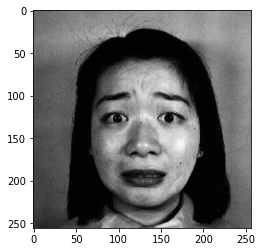

In [0]:
plt.imshow(img[0].reshape(256,256),cmap='gray')

In [0]:
dataset = [img,target]

In [0]:
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Conv2DTranspose, Embedding, Reshape, Concatenate, Dropout 
from tensorflow.keras.activations import relu
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, RMSprop

In [0]:
n_classes = 7
latent_dim = 100

In [0]:
def get_descriminator(in_shape=(256,256,1), n_classes=7):

  label = Input(shape = (1,))
  li = Embedding(n_classes+1,50)(label)

  li = Dense(256*256)(li)

  li = Reshape((256,256,1))(li)

  image = Input(shape=in_shape)

  merge = Concatenate()([image, li])

  fe = Conv2D(128,(3,3), strides=(2,2), padding = 'same')(merge)
  fe = LeakyReLU()(fe)

  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
  fe = LeakyReLU()(fe)

  fe = Flatten()(fe)
  fe = Dropout(0.4)(fe)

  out_layer = Dense(1, activation='sigmoid')(fe)

  model = Model([image, label], out_layer)

  opt = RMSprop(lr=0.0001, decay=1e-6)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
 
  return model


In [0]:
def get_generator(latent_dim, n_classes = 7):

  label = Input(shape=(1,))

  li = Embedding(n_classes+1,50)(label)

  li = Dense(42 * 42)(li)
  li = Reshape((42,42,1))(li)

  latent = Input(shape=(latent_dim,))

  gen = Dense(128 * 42 * 42)(latent)
  gen = LeakyReLU()(gen)
  gen = Reshape((42, 42, 128))(gen)

  merge = Concatenate()([gen, li])

  gen = Conv2DTranspose(128, (4,4), strides=(3,3), padding='valid')(merge)
  gen = LeakyReLU()(gen)
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='valid')(gen)
  gen = LeakyReLU()(gen)

  out_layer = Conv2D(1, (8,8), activation='tanh', padding='same')(gen)

  model = Model([latent, label], out_layer)
  return model

In [0]:
def cgan(genmodel,discmodel):

  discmodel.trainable = False

  g_noise, g_label = genmodel.input
  g_output = genmodel.output

  cgan_output = discmodel([g_output, g_label])

  model = Model([g_noise, g_label], cgan_output)

  opt = RMSprop(lr=0.0001, decay=1e-6)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [0]:
def generate_real_samples(dataset, n_samples):
	
	images, labels = dataset

	ix = np.random.randint(0, images.shape[0], n_samples)
	
	X, labels = images[ix], labels[ix]
	
	y = np.ones((n_samples, 1))
	return [X, labels], y

In [0]:
def generate_latent_points(latent_dim, n_samples, n_classes=7):
	
	x_input = np.random.randn(latent_dim * n_samples)
	
	z_input = x_input.reshape(n_samples, latent_dim)
	
	labels = np.random.randint(0, n_classes, n_samples)
	return [z_input, labels]
 

def generate_fake_samples(generator, latent_dim, n_samples):
	
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	
	images = generator.predict([z_input, labels_input])
	
	y = np.zeros((n_samples, 1))
	return [images, labels_input], y

In [0]:
def plot(model,seed):
  
  
  predictions = model(seed, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(2, 2, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')
  plt.show()

In [0]:
test_input,y=generate_latent_points(100, 4)
y=np.asarray([0,1,2,3])
seed = [test_input,y]

In [0]:
def train(genmodel, discmodel, cganmodel, dataset, latent_dim, n_epochs=100, n_batch=8):
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  d1=[]
  d2=[]
  g=[]
  for i in range(n_epochs):
    
    for j in range(bat_per_epo):
      display.clear_output(wait=True)
      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = discmodel.train_on_batch([X_real, labels_real], y_real)

      [X_fake, labels], y_fake = generate_fake_samples(genmodel, latent_dim, half_batch)
      d_loss2, _ = discmodel.train_on_batch([X_fake, labels], y_fake)

      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)

      y_gan = np.ones((n_batch, 1))

      g_loss = cganmodel.train_on_batch([z_input, labels_input], y_gan)

      d1.append(d_loss1)
      d2.append(d_loss2)
      g.append(g_loss)
      
    print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    
    plot(genmodel,seed)
    

  return d1,d2,g
      


In [0]:
discmodel = get_descriminator()
genmodel = get_generator(latent_dim)
#genmodel = load_model('/content/drive/My Drive/DL/cgan_generator.h5')

cganmodel = cgan(genmodel,discmodel)

In [0]:
d1,d2,g=train(genmodel, discmodel, cganmodel, dataset, latent_dim)

KeyboardInterrupt: ignored

In [0]:
#angry - disgust - fear - happy

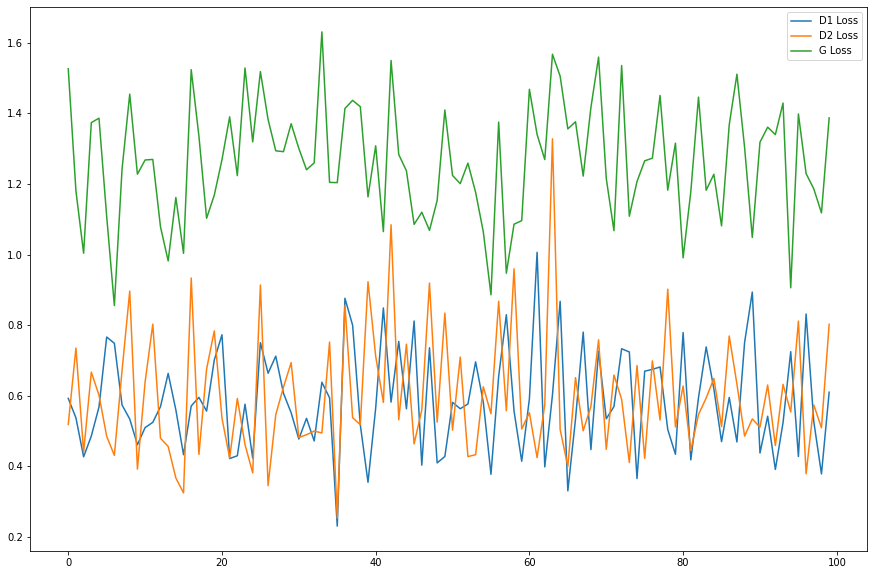

In [0]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(15,10))
plt.plot(d1[-100:],label='D1 Loss')
plt.plot(d2[-100:],label='D2 Loss')
plt.plot(g[-100:],label='G Loss')
plt.legend()
plt.show()

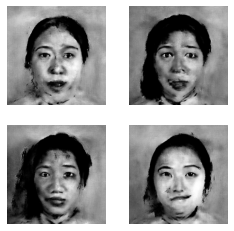

In [0]:
plot(genmodel,generate_latent_points(100, 4))

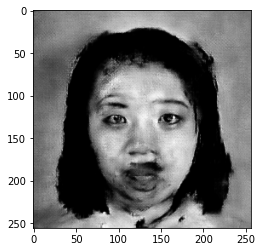

In [0]:
plt.imshow(genmodel(seed,training=False)[0].numpy().reshape(256,256),cmap='gray')

In [0]:
cganmodel.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 225792)       22804992    input_4[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        400         input_3[0][0]                    
____________________________________________________________________________________________

In [0]:
discmodel([img[0:4],np.array([0,1,2,3])])

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.09875443],
       [0.12507987],
       [0.70352983],
       [0.54619193]], dtype=float32)>